In [1]:
%config Completer.use_jedi = False

In [2]:
import gym
import copy
import random
import json
import torch
from collections import defaultdict, deque
from typing import Sequence

import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam, lr_scheduler

In [3]:
EMPTY_MOVE = (-1, -1)

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        self.gameOver = False
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----' * self.n_cols + '-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----' * self.n_cols + '-')

    def getState(self):
        return self.getHash(), self.getEmptySpaces(), self.curTurn

    def action_from_int(self, action_int):
        return int(action_int / self.n_cols), int(action_int % self.n_cols)

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action: Sequence[int]):
        if self.board[action[0], action[1]] != 0:
            self.curTurn = -self.curTurn
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [5]:
class AgentQ:
    def __init__(self, alpha=0.05, gamma=0.9):
        self.alpha = alpha
        self.gamma = gamma
        self.q = defaultdict(dict)

    @staticmethod
    def state_to_string(state):
        return ''.join(['%s' % (x + 1) for x in state.ravel()])

    @staticmethod
    def get_empty_spaces(state, done):
        res = np.where(state == 0)
        if len(res[0]) == 0 or done:
            return [EMPTY_MOVE]
        else:
            return [(i, j) for i, j in zip(res[0], res[1])]

    def get_policy(self):
        policy = {}
        for state, action_dict in self.q.items():
            best_action = max(action_dict.items(), key=lambda x: x[1])[0]
            policy[state] = best_action
        return policy

    def init_q(self, state, empty_spaces):
        if state not in self.q:
            actions = [tuple(map(int, action)) for action in empty_spaces]
            self.q[state] = {action: random.random() for action in actions}

    def act(self, state):
        empty_spaces = self.get_empty_spaces(state, False)
        state = self.state_to_string(state)
        self.init_q(state, empty_spaces)
        return max(self.q[state].items(), key=lambda x: x[1])[0]

    def update(self, state, action, next_state, reward, done):
        empty_spaces = self.get_empty_spaces(state, False)
        state = self.state_to_string(state)
        self.init_q(state, empty_spaces)
        if next_state is None:
            self.q[state][action] = reward
        else:
            empty_spaces = self.get_empty_spaces(next_state, done)
            next_state = self.state_to_string(next_state)
            if done:
                next_state_value = 0
            else:
                self.init_q(next_state, empty_spaces)
                next_state_value = max(self.q[next_state].values())
            self.q[state][action] = self.q[state][action] + self.alpha * (
                reward
                + self.gamma * next_state_value
                - self.q[state][action]
            )

In [6]:
class Trainer:
    def __init__(self, env: TicTacToe, agent_cross, agent_zero, epsilon=0.2):
        self.env = env
        self.agent_cross = agent_cross
        self.agent_zeros = agent_zero
        self.epsilon = epsilon
        self.cross_s = None
        self.cross_a = None
        self.zeros_s = None
        self.zeros_a = None
        self.prime_cross_s = None
        self.prime_cross_a = None
        self.prime_zeros_s = None
        self.prime_zeros_a = None
        self.done = False
        self.reward_zeros = 0
        self.reward_cross = 0
        self.step = 0
        self.login_step = 1
        self.cur_turn = 1

    def reset(self):
        self.env.reset()
        self.done = False
        self.cross_s = self.env.board.copy()
        self.cross_a = self.agent_cross.act(self.env.board)
        self.zeros_s = None
        self.zeros_a = None
        self.prime_cross_s = None
        self.prime_zeros_s = None
        self.prime_cross_a = None
        self.prime_zeros_a = None
        self.reward_zeros = 0
        self.reward_cross = 0
        self.cur_turn = 1

    def set_action(self):
        if self.cur_turn == 1:
            self.prime_cross_a = self.cross_a
            if self.done:
                self.cross_a = EMPTY_MOVE
            elif random.random() > self.epsilon:
                self.cross_a = self.agent_cross.act(self.cross_s)
            else:
                self.cross_a = tuple(random.choice(self.env.getEmptySpaces()))
        else:
            self.prime_zeros_a = self.zeros_a
            if self.done:
                self.zeros_a = EMPTY_MOVE
            elif random.random() > self.epsilon:
                self.zeros_a = self.agent_zeros.act(self.zeros_s)
            else:
                self.zeros_a = tuple(random.choice(self.env.getEmptySpaces()))

    def parse_reward(self, reward):
        self.reward_cross = reward
        self.reward_zeros = -reward
        if reward == -10:
            if self.cur_turn == 1:
                self.reward_cross = 0
                self.reward_zeros = -10
            else:
                self.reward_cross = -10
                self.reward_zeros = 0

    def env_step(self):
        self.step += 1
        if self.cur_turn == 1:
            self.prime_zeros_s = self.zeros_s
            _, reward, self.done, _ = self.env.step(self.cross_a)
            self.cur_turn = self.env.curTurn
            self.zeros_s = self.env.board.copy()
            self.set_action()
            self.parse_reward(reward)
            if self.prime_zeros_s is not None and self.prime_zeros_a is not None:
                self.agent_zeros.update(
                    self.prime_zeros_s,
                    self.prime_zeros_a,
                    self.zeros_s,
                    self.reward_zeros,
                    self.done,
                )
            if self.done:
                self.agent_cross.update(
                    self.cross_s, self.cross_a, None, self.reward_cross, self.done
                )
        else:
            self.prime_cross_s = self.cross_s
            _, reward, self.done, _ = self.env.step(self.zeros_a)
            self.cur_turn = self.env.curTurn
            self.cross_s = self.env.board.copy()
            self.set_action()
            self.parse_reward(reward)
            if self.prime_cross_a is not None:
                self.agent_cross.update(
                    self.prime_cross_s,
                    self.prime_cross_a,
                    self.cross_s,
                    self.reward_cross,
                    self.done,
                )
            if self.done:
                self.agent_zeros.update(
                    self.zeros_s, self.zeros_a, None, self.reward_zeros, self.done
                )

    def evaluate_policy(self):
        cross_rewards = []
        zeros_rewards = []
        for i in range(1000):
            self.reset()
            done = False
            reward = 0
            while not done:
                if self.env.curTurn == 1:
                    state_c = self.env.board
                    action_c = self.agent_cross.act(state_c)
                    _, reward, done, _ = self.env.step(action_c)
                else:
                    action_z = random.choice(self.env.getEmptySpaces())
                    _, reward, done, _ = self.env.step(action_z)
            self.parse_reward(reward)
            cross_rewards.append(self.reward_cross)
            self.reset()
            done = False
            while not done:
                if self.env.curTurn == -1:
                    state_z = self.env.board
                    action_z = self.agent_zeros.act(state_z)
                    _, reward, done, _ = self.env.step(action_z)
                else:
                    action_c = random.choice(self.env.getEmptySpaces())
                    _, reward, done, _ = self.env.step(action_c)
            self.parse_reward(reward)
            zeros_rewards.append(self.reward_zeros)
        return np.mean(cross_rewards), np.mean(zeros_rewards)

    def train(self, iterations):
        rewards_cross = []
        rewards_zeros = []
        for i in range(iterations):
            self.reset()

            while not self.done:
                self.env_step()
            if self.step // self.login_step > 30000:
                mean_cross_reward, mean_zeros_reward = self.evaluate_policy()
                rewards_cross.append(mean_cross_reward)
                rewards_zeros.append(mean_zeros_reward)
                self.login_step += 1
        return rewards_cross, rewards_zeros

# Часть 1

## 1.1 - Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3. 

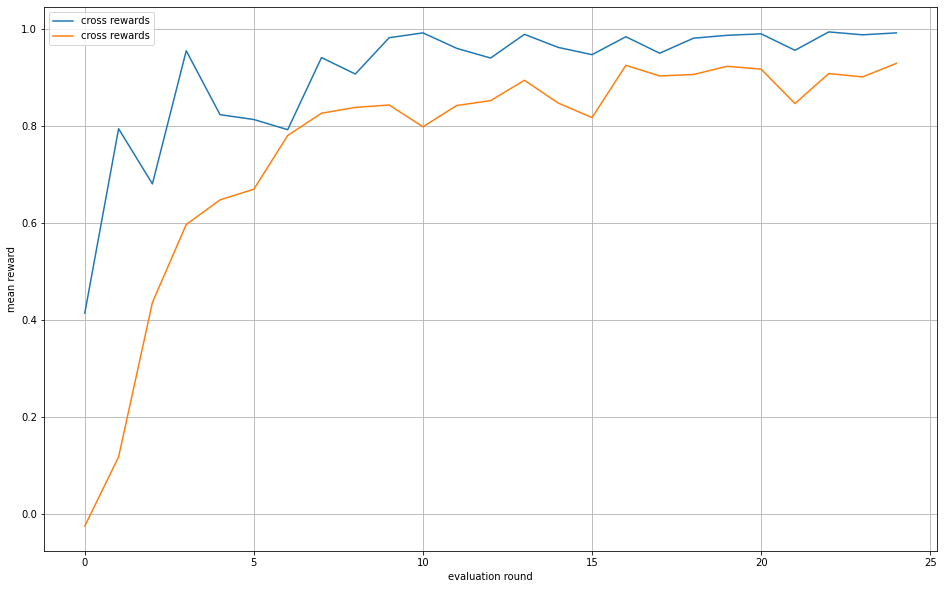

In [7]:
N_COLS, N_ROWS, N_WINS = 3, 3, 3

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentQ()
agent_zeros = AgentQ()
trainer = Trainer(env, agent_cross, agent_zeros)
rewards_cross, rewards_zeros = trainer.train(100_000)

with open(f"{N_ROWS}_q_policy_cross.json", "w") as f:
    json.dump(agent_cross.get_policy(), f)
with open(f"{N_ROWS}_q_policy_zeros.json", "w") as f:
    json.dump(agent_zeros.get_policy(), f)
    
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

## 1.2 - Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

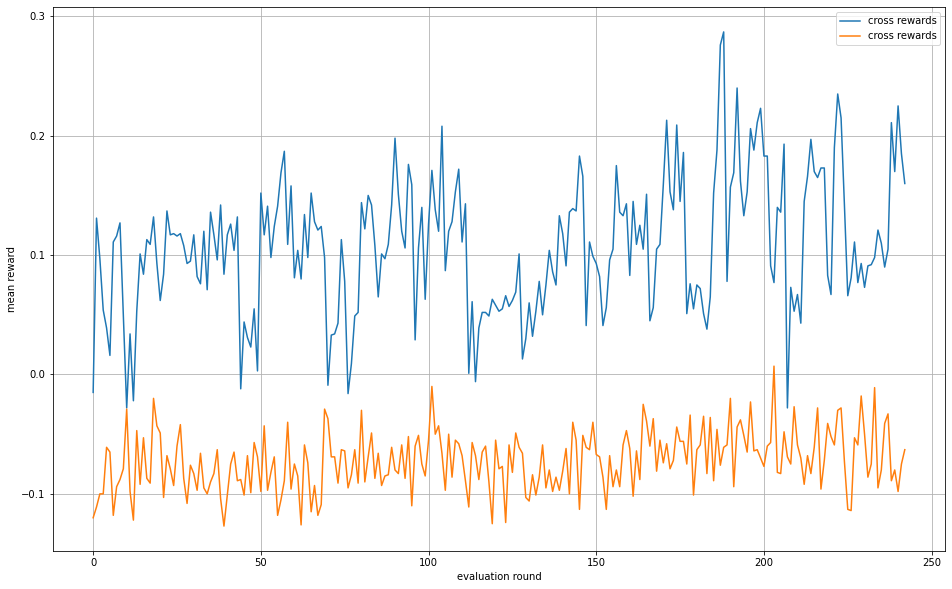

In [8]:
N_COLS, N_ROWS, N_WINS = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentQ(alpha=0.05, gamma=0.9)
agent_zeros = AgentQ(alpha=0.05, gamma=0.9)
trainer = Trainer(env, agent_cross, agent_zeros, epsilon=0.2)
rewards_cross, rewards_zeros = trainer.train(500_000)

with open(f"{N_ROWS}_q_policy_cross.json", "w") as f:
    json.dump(agent_cross.get_policy(), f)
with open(f"{N_ROWS}_q_policy_zeros.json", "w") as f:
    json.dump(agent_zeros.get_policy(), f)
    
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

In [ ]:
N_COLS, N_ROWS, N_WINS = 5, 5, 4

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentQ(alpha=0.05, gamma=0.9)
agent_zeros = AgentQ(alpha=0.05, gamma=0.9)
trainer = Trainer(env, agent_cross, agent_zeros, epsilon=0.2)
rewards_cross, rewards_zeros = trainer.train(500_000)

with open(f"{N_ROWS}_q_policy_cross.json", "w") as f:
    json.dump(agent_cross.get_policy(), f)
with open(f"{N_ROWS}_q_policy_zeros.json", "w") as f:
    json.dump(agent_zeros.get_policy(), f)
    
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

# Часть 2

## 2.1 - Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов

In [ ]:
class QModel(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=(3, 3), padding=(1, 1)),
        )
        self.head = nn.Linear(state_dim * 16, state_dim)

    def forward(self, x):
        x = self.fc(x).view(x.shape[0], -1)
        return self.head(x)

    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.xavier_uniform_(m.weight)

In [ ]:
class ExpirienceReplay(deque):
    def sample(self, size):
        p = np.array([abs(v[-2]) + 0.1 for v in self])
        p = p / p.sum()
        batch = random.choices(self, weights=p, k=size)
        return list(zip(*batch))

In [ ]:
class AgentDQN:
    def __init__(
        self,
        state_dim,
        gamma=0.99,
        buffer_size=128_000,
        learning_rate=1e-3,
        device="cuda",
        batch_size=128,
        initial_steps=1024,
        steps_per_update=4
    ):
        self.steps = 0
        self.device = device
        self.gamma = gamma
        self.batch_size = batch_size
        self.initial_steps = initial_steps
        self.steps_per_update = steps_per_update
        self.model = QModel(state_dim).to(device)
        self.buffer = ExpirienceReplay(maxlen=buffer_size)
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.criteria = nn.MSELoss()
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10000, gamma=0.8)

    def consume_transition(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        batch = self.buffer.sample(self.batch_size)
        state, action, next_state, reward, done = batch
        state = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(1)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.tensor(np.array(next_state, dtype=np.float32)).unsqueeze(1)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.int32))
        return state, action, next_state, reward, done

    def train_step(self, batch):
        if not self.model.training:
            self.model.train()
        self.optimizer.zero_grad()
        state, action, next_state, reward, done = batch
        current_q = self.model(state.to(self.device))
        next_q = self.model(next_state.to(self.device))
        next_action = torch.argmax(next_q, 1)
        next_target_q = self.model(next_state.to(self.device))
        action_reward = current_q.gather(1, action.view(-1, 1).to(self.device))
        next_actions_reward = next_target_q.gather(1, next_action.view(-1, 1))
        next_actions_reward = next_actions_reward.squeeze(1) * (
            1 - done.to(self.device)
        )
        loss = self.criteria(
            action_reward.squeeze(1),
            reward.to(self.device) + self.gamma * next_actions_reward,
        )
        loss.backward()
        self.optimizer.step()
        if self.steps > 1_000_000:
            self.scheduler.step(loss)

    def act(self, state):
        if self.model.training:
            self.model.eval()
        state = torch.tensor(np.array(state)).view(1, 1, state.shape[-2], state.shape[-1])
        state = state.float().to(self.device)
        action_rewards = self.model(state).detach().cpu().numpy()
        index = np.argmax(action_rewards.squeeze())
        return index // state.shape[-1], index % state.shape[-1]

    def update(self, state, action, next_state, reward, done):
        if next_state is None:
            next_state = state
        action = action[0] * state.shape[-1] + action[1]
        self.consume_transition((state, action, next_state, reward, done))
        self.steps += 1
        if self.steps > self.initial_steps:
            if self.steps % self.steps_per_update == 0:
                batch = self.sample_batch()
                self.train_step(batch)

In [ ]:
N_ROWS, N_COLS, N_WINS = 3, 3, 3

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDQN(N_ROWS * N_COLS, device="cuda")
agent_zeros = AgentDQN(N_ROWS * N_COLS, device="cuda")
env = Trainer(env, agent_cross, agent_zeros)
env.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

In [ ]:
N_ROWS, N_COLS, N_WINS = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDQN(N_ROWS * N_COLS, device="cuda")
agent_zeros = AgentDQN(N_ROWS * N_COLS, device="cuda")
env = Trainer(env, agent_cross, agent_zeros)
env.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

In [ ]:
N_ROWS, N_COLS, N_WINS = 5, 5, 5

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDQN(N_ROWS * N_COLS, device="cpu")
agent_zeros = AgentDQN(N_ROWS * N_COLS, device="cpu")
env = Trainer(env, agent_cross, agent_zeros)
env.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

## 2.2 Реализуйте Double DQN и/или Dueling DQN.

In [ ]:
class AgentDDQN:
    def __init__(
        self,
        state_dim,
        gamma=0.99,
        buffer_size=128_000,
        learning_rate=1e-3,
        device="cuda",
        batch_size=128,
        initial_steps=1024,
        steps_per_update=4,
        steps_per_target_update=4000,
    ):
        self.steps = 0  # Do not change
        self.device = device
        self.gamma = gamma
        self.batch_size = batch_size
        self.initial_steps = initial_steps
        self.steps_per_update = steps_per_update
        self.steps_per_target_update = steps_per_target_update
        self.model = QModel(state_dim).to(device)  # Torch model
        self.target_model = QModel(state_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.buffer = ExpirienceReplay(maxlen=buffer_size)
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.criteria = nn.MSELoss()
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10000, gamma=0.8)

    def consume_transition(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        batch = self.buffer.sample(self.batch_size)
        state, action, next_state, reward, done = batch
        state = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(1)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.tensor(np.array(next_state, dtype=np.float32)).unsqueeze(1)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.int32))
        return state, action, next_state, reward, done

    def train_step(self, batch):
        if not self.model.training:
            self.model.train()
        self.optimizer.zero_grad()
        state, action, next_state, reward, done = batch
        current_q = self.model(state.to(self.device))
        next_q = self.model(next_state.to(self.device))
        next_action = torch.argmax(next_q, 1)
        with torch.no_grad():
            next_target_q = self.target_model(next_state.to(self.device))
        action_reward = current_q.gather(1, action.view(-1, 1).to(self.device))
        next_actions_reward = next_target_q.gather(1, next_action.view(-1, 1))
        next_actions_reward = next_actions_reward.squeeze(1) * (
            1 - done.to(self.device)
        )
        loss = self.criteria(
            action_reward.squeeze(1),
            reward.to(self.device) + self.gamma * next_actions_reward,
        )
        loss.backward()
        self.optimizer.step()
        if self.steps > 1_000_000:
            self.scheduler.step(loss)

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

    def act(self, state):
        if self.model.training:
            self.model.eval()
        state = torch.tensor(np.array(state)).view(1, 1, state.shape[-2], state.shape[-1])
        state = state.float().to(self.device)
        action_rewards = self.model(state).detach().cpu().numpy()
        index = int(np.argmax(action_rewards.squeeze()))
        return index // state.shape[-1], index % state.shape[-1]

    def update(self, state, action, next_state, reward, done):
        if next_state is None:
            next_state = state
        action = action[0] * state.shape[-1] + action[1]
        self.consume_transition((state, action, next_state, reward, done))
        self.steps += 1
        if self.steps > self.initial_steps:
            if self.steps % self.steps_per_update == 0:
                batch = self.sample_batch()
                self.train_step(batch)
            if self.steps % self.steps_per_target_update == 0:
                self.update_target_network()

In [ ]:
N_ROWS, N_COLS, N_WINS = 3, 3, 3

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDDQN(N_ROWS * N_COLS)
agent_zeros = AgentDDQN(N_ROWS * N_COLS)
env = Trainer(env, agent_cross, agent_zeros)
env.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

In [ ]:
N_ROWS, N_COLS, N_WINS = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDDQN(N_ROWS * N_COLS)
agent_zeros = AgentDDQN(N_ROWS * N_COLS)
env = Trainer(env, agent_cross, agent_zeros)
env.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

In [ ]:
N_ROWS, N_COLS, N_WINS = 5, 5, 5

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDDQN(N_ROWS * N_COLS)
agent_zeros = AgentDDQN(N_ROWS * N_COLS)
env = Trainer(env, agent_cross, agent_zeros)
env.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(rewards_cross, label="cross rewards")
ax.plot(rewards_zeros, label="cross rewards")
ax.set_xlabel("evaluation round")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

# Часть 3

## 3.1 -Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [ ]:
class Node:
    def __init__(self, state, move=None, parent=None, empty_spaces=None, turn=None):
        self.move = move
        self.parentNode = parent
        self.childNodes = defaultdict(list)
        self.wins = 0
        self.visits = 0
        if state is None:
            self.untriedMoves = {}
        else:
            self.untriedMoves = {
                state: list(map(tuple, empty_spaces))
            }
        self.turn = turn

    def utc_select_child(self, state):

        s = max(
            self.childNodes[state],
            key=lambda x: x.wins / x.visits + sqrt(2 * log(self.visits) / x.visits),
        )
        return s

    def add_child(self, new_state, state, move, empty_spaces, turn):

        n = Node(
            state=new_state,
            move=move,
            parent=self,
            empty_spaces=empty_spaces,
            turn=turn,
        )
        self.untriedMoves[state].remove(move)
        self.childNodes[state].append(n)
        return n

    def update(self, result):
        self.visits += 1
        self.wins += result

    def update_untried_moves(self, state, empty_spaces):
        if state not in self.untriedMoves:
            self.untriedMoves[state] = list(map(tuple, empty_spaces)

In [ ]:
def uct(env: TicTacToe, itermax, turn):

    if turn == 1:
        rootnode = Node(state=env.getHash(), empty_spaces=env.getEmptySpaces(), turn=turn)
    else:
        rootnode = Node(state=None, empty_spaces=env.getEmptySpaces(), turn=turn)

    env = TicTacToe(3, 3, 3)
    for i in range(itermax):
        reward = 0
        env.reset()
        state = env.getHash()
        node = rootnode
        if env.curTurn != rootnode.turn:
            _, reward, _, _ = env.step(random.choice(env.getEmptySpaces()))
            state = env.getHash()
            node.update_untried_moves(state, env.getEmptySpaces())
        
        
        while len(node.untriedMoves[state]) == 0 and len(node.childNodes[state]) > 0:
            node = node.utc_select_child(state)
            _, reward, _, _ = env.step(node.move)
            if not env.gameOver:
                _, reward, _, _ = env.step(random.choice(env.getEmptySpaces()))
                state = env.getHash()
                if env.gameOver:
                    node.update_untried_moves(state, [])
                    break
                else:
                    node.update_untried_moves(state, env.getEmptySpaces())
            else:
                state = env.getHash()
                break

        if node.untriedMoves[state]:
            if env.curTurn != rootnode.turn:
                _, reward, _, _ = env.step(random.choice(env.getEmptySpaces()))
                node.update_untried_moves(state, env.getEmptySpaces())
            move = tuple(random.choice(node.untriedMoves[state]))
            _, reward, _, _ = env.step(move)
            if not env.gameOver:
                _, reward, _, _ = env.step(random.choice(env.getEmptySpaces()))
                new_state = env.getHash()
                node = node.add_child(
                    new_state=new_state,
                    state=state,
                    move=move,
                    empty_spaces=env.getEmptySpaces(),
                    turn=env.curTurn,
                )
            else:
                node = node.add_child(
                    new_state=env.getHash(),
                    state=state,
                    move=move,
                    empty_spaces=[],
                    turn=env.curTurn,
                )

        # rollout
        while not env.gameOver:
            _, reward, _, _ = env.step(random.choice(env.getEmptySpaces()))

        # backprop
        while node is not None:
            node.update(reward * rootnode.turn)
            node = node.parentNode

    return rootnode

## 3.2 - Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.